#### Task 5: Decision Trees and Random Forests

1. Import libraries & load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn import set_config
import joblib
import warnings
warnings.filterwarnings("ignore")
set_config(display='diagram')
RANDOM_STATE = 42

In [3]:
df = pd.read_csv('Heart_Disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (1025, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


2. Detect target column and prepare X, y

In [5]:
# Common names: 'target', 'Target', 'heart_disease', 'HeartDisease' — fallback to last column
potential_targets = ['target', 'Target', 'TARGET', 'heart_disease', 'HeartDisease', 'disease', 'output', 'label']
target_col = None
for t in potential_targets:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    target_col = df.columns[-1]   # fallback
    print(f"No common target column found; using last column as target: '{target_col}'")

X = df.drop(columns=[target_col])
y = df[target_col]
print("Target distribution:\n", y.value_counts())

Target distribution:
 target
1    526
0    499
Name: count, dtype: int64


3. Identify numeric/categorical features

In [6]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Treat low-cardinality numeric columns as categorical (optional heuristic)
for c in numeric_cols.copy():
    if X[c].nunique() <= 10:
        cat_cols.append(c)
        numeric_cols.remove(c)

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


4. Preprocessing pipelines

In [8]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())   # scaling isn't required for trees but okay to include
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop')

5. Train / test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y if len(np.unique(y)) > 1 else None, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (820, 13) Test shape: (205, 13)


6. Decision Tree: baseline

In [10]:
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

dt_pipeline.fit(X_train, y_train)

y_pred = dt_pipeline.predict(X_test)
print("Decision Tree — Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# cross-validation on full data
cv_scores = cross_val_score(dt_pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print("Decision Tree CV accuracies:", cv_scores, "mean:", cv_scores.mean())

Decision Tree — Test accuracy: 0.9853658536585366

Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

Confusion matrix:
 [[100   0]
 [  3 102]]
Decision Tree CV accuracies: [1.         0.98536585 0.98536585 1.         0.98536585] mean: 0.9912195121951219


7. Visualize the trained tree (matplotlib)

In [11]:
# Get final feature names after preprocessing
def get_feature_names(preprocessor, numeric_cols, cat_cols):
    feature_names = []
    if numeric_cols:
        feature_names.extend(numeric_cols)
    if cat_cols:
        # Access fitted OneHotEncoder inside the ColumnTransformer
        try:
            onehot = preprocessor.named_transformers_['cat'].named_steps['onehot']
            onehot_names = list(onehot.get_feature_names_out(cat_cols))
            feature_names.extend(onehot_names)
        except Exception:
            # fallback: create generic names for cat features
            for c in cat_cols:
                feature_names.append(f"{c}")
    return feature_names

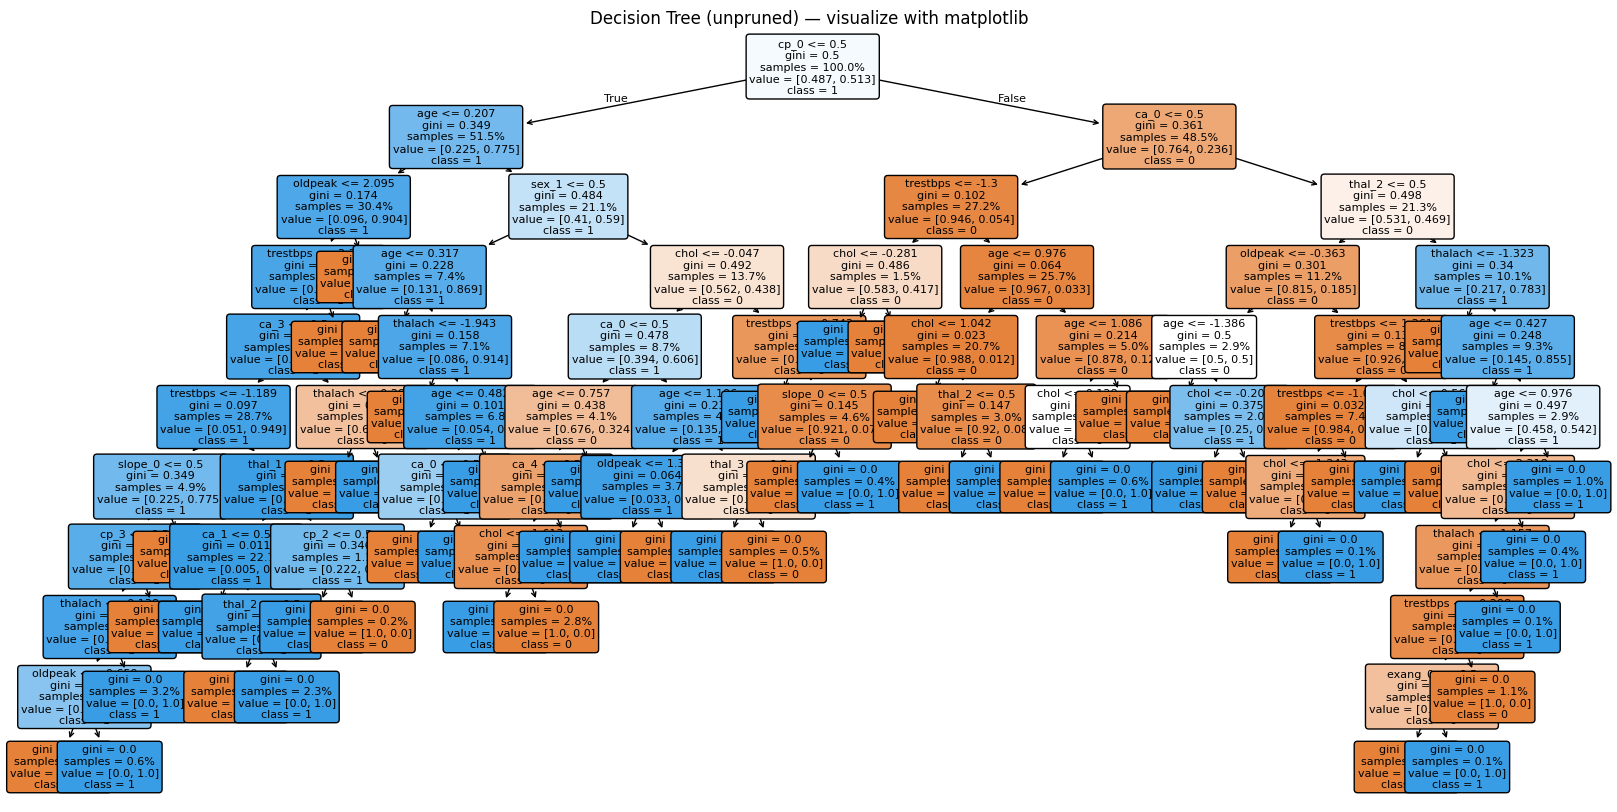

In [12]:
# Ensure preprocessor is fitted (it is after pipeline.fit)
fitted_preprocessor = dt_pipeline.named_steps['preprocessor']
feature_names = get_feature_names(fitted_preprocessor, numeric_cols, cat_cols)

tree_est = dt_pipeline.named_steps['clf']

plt.figure(figsize=(20,10))
plot_tree(tree_est, feature_names=feature_names, class_names=[str(c) for c in tree_est.classes_],
          filled=True, rounded=True, proportion=True, fontsize=8)
plt.title("Decision Tree (unpruned) — visualize with matplotlib")
plt.show()

8. Control overfitting: vary max_depth and compare

In [13]:
depths = [2, 3, 4, 5, 6, 8, None]
results = []
for d in depths:
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE))])
    clf.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    results.append((d, train_acc, test_acc))
    print(f"max_depth={d} -> train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")

max_depth=2 -> train_acc=0.7695, test_acc=0.7220
max_depth=3 -> train_acc=0.8500, test_acc=0.8439
max_depth=4 -> train_acc=0.8902, test_acc=0.8488
max_depth=5 -> train_acc=0.9244, test_acc=0.8878
max_depth=6 -> train_acc=0.9622, test_acc=0.9024
max_depth=8 -> train_acc=0.9951, test_acc=0.9512
max_depth=None -> train_acc=1.0000, test_acc=0.9854


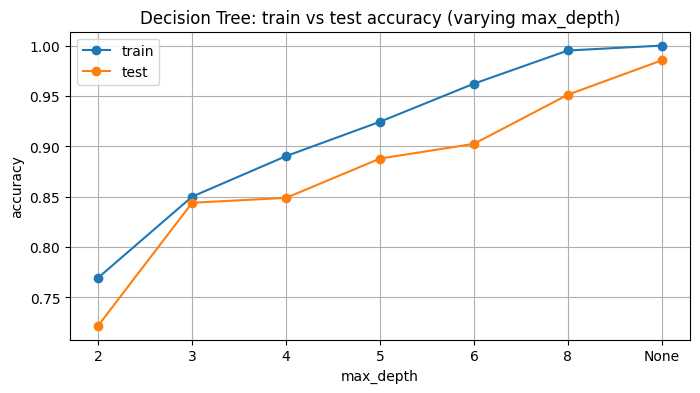

In [14]:
# Quick plot
depth_labels = [str(d) for d,_,_ in results]
train_scores = [t for _, t, _ in results]
test_scores = [te for _, _, te in results]
plt.figure(figsize=(8,4))
plt.plot(depth_labels, train_scores, marker='o', label='train')
plt.plot(depth_labels, test_scores, marker='o', label='test')
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Decision Tree: train vs test accuracy (varying max_depth)")
plt.legend()
plt.grid(True)
plt.show()

9. Random Forest baseline & compare

In [15]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
])
rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
print("Random Forest — Test accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification report:\n", classification_report(y_test, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))

cv_scores_rf = cross_val_score(rf_pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print("Random Forest CV accuracies:", cv_scores_rf, "mean:", cv_scores_rf.mean())

Random Forest — Test accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

Confusion matrix:
 [[100   0]
 [  0 105]]
Random Forest CV accuracies: [1.         1.         1.         1.         0.98536585] mean: 0.9970731707317073


10. Feature importances (from Random Forest)

In [16]:
# Extract feature names (same function works)
fitted_preproc_rf = rf_pipeline.named_steps['preprocessor']
feature_names_rf = get_feature_names(fitted_preproc_rf, numeric_cols, cat_cols)

rf_est = rf_pipeline.named_steps['clf']
importances = rf_est.feature_importances_

feat_imp = pd.DataFrame({'feature': feature_names_rf, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False).reset_index(drop=True)
display(feat_imp.head(20))

,feature,importance
0,cp_0,0.094379
1,oldpeak,0.091564
2,thalach,0.089939
3,thal_2,0.088153
4,age,0.078956
5,chol,0.068414
6,ca_0,0.066237
7,thal_3,0.057012
8,trestbps,0.054864
9,exang_0,0.042422


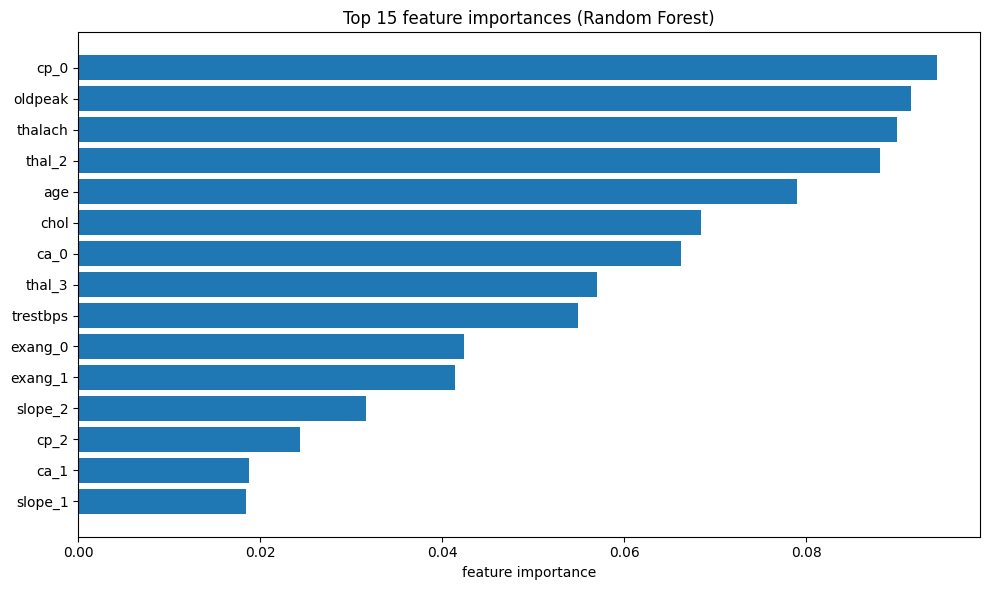

In [17]:
# Plot top 15
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'].head(15)[::-1], feat_imp['importance'].head(15)[::-1])
plt.xlabel("feature importance")
plt.title("Top 15 feature importances (Random Forest)")
plt.tight_layout()
plt.show()

11. Hyperparameter tuning (example: Decision Tree then Random Forest)

In [18]:
# 1) Decision Tree Grid Search (quick example)
dt_param_grid = {
    'clf__max_depth': [3, 4, 5, 6, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__criterion': ['gini', 'entropy']
}
dt_gs = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
dt_gs.fit(X_train, y_train)
print("Best DT params:", dt_gs.best_params_)
print("Best DT CV score:", dt_gs.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best DT params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 2}
Best DT CV score: 0.9865853658536585


In [19]:
# 2) Random Forest Grid Search (example; can be heavy)
rf_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 8, 12],
    'clf__min_samples_split': [2, 5]
}
rf_gs = GridSearchCV(rf_pipeline, rf_param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=1)
rf_gs.fit(X_train, y_train)
print("Best RF params:", rf_gs.best_params_)
print("Best RF CV score:", rf_gs.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best RF params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best RF CV score: 0.9817073170731707


12. Final evaluation & ROC (if binary)

Using best estimator: DecisionTreeClassifier
Final accuracy: 0.9853658536585366
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

ROC AUC: 0.9857142857142858


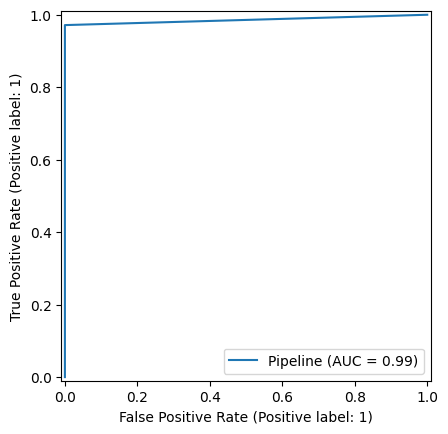

In [20]:
# Use best estimator between rf_gs and dt_gs (choose by cv score)
best_est = rf_gs.best_estimator_ if rf_gs.best_score_ >= dt_gs.best_score_ else dt_gs.best_estimator_
print("Using best estimator:", best_est.named_steps['clf'].__class__.__name__)

y_pred_best = best_est.predict(X_test)
print("Final accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

# ROC AUC (if binary and predict_proba available)
if hasattr(best_est.named_steps['clf'], "predict_proba") and len(np.unique(y)) == 2:
    y_proba = best_est.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", auc)
    RocCurveDisplay.from_estimator(best_est, X_test, y_test)
    plt.show()

13. Save models & artifacts

In [21]:
import os
os.makedirs("models", exist_ok=True)
joblib.dump(dt_pipeline, "models/dt_pipeline_baseline.joblib")
joblib.dump(rf_pipeline, "models/rf_pipeline_baseline.joblib")
joblib.dump(best_est, "models/best_model.joblib")
print("Saved models to ./models/")

Saved models to ./models/
